In [1]:
import pyvinecopulib as pv
import seaborn
from matplotlib import pyplot
from PySDM import Formulae
from PySDM.physics import si
from PySDM.initialisation.spectra import Lognormal
from open_atmos_jupyter_utils import show_plot
import numpy as np

In [2]:
import matplotlib
font = {'family' : 'monospace',
        'weight' : 'light',
        'size'   : 13
       }
matplotlib.rc('font', **font)  
matplotlib.pyplot.tight_layout()

<Figure size 432x288 with 0 Axes>

In [3]:
freezing_fit_a = -0.5
freezing_fit_b = 10
lognormal_median = 5*si.um**2
lognormal_g_mean = 1.75

In [4]:
formulae = Formulae(
    freezing_temperature_spectrum='Niemand_et_al_2012',
    constants={
        'NIEMAND_A': freezing_fit_a,
        'NIEMAND_B': freezing_fit_b 
    }
)
spectrum = Lognormal(norm_factor=1, m_mode=lognormal_median, s_geom=lognormal_g_mean)

In [5]:
T_range = (230 * si.K, 255 * si.K)
A_range = (.05 * si.um**2, 40 * si.um**2)

label_T=f'normalised freezing T within {T_range} K' 
label_A=f'normalised insoluble A within {tuple(np.asarray(A_range) / si.um**2)} $μm^2$'

In [6]:
N = 256
T = np.linspace(*T_range, N)
A = np.linspace(*A_range, N)

grid = np.meshgrid(T, A)

def pdf(T, A):
    return formulae.freezing_temperature_spectrum.pdf(T, A) * spectrum.pdf(A)

def cdfA(A):
    return spectrum.cdf(A)

def cdfT(T):
    return formulae.freezing_temperature_spectrum.cdf(T, spectrum.median)

def invcdfA(x):
    return spectrum.percentiles(x)

def invcdfT(x):
    return formulae.freezing_temperature_spectrum.invcdf(x, spectrum.median)

def _T_to_01(T):
    return (T - T_range[0]) / np.diff(T_range)

def _01_to_T(x):
    return x * np.diff(T_range) + T_range[0]

def _A_to_01(A):
    return (A - A_range[0]) / np.diff(A_range)
    
def _01_to_A(x):
    return x * np.diff(A_range) + A_range[0]


dT = T[1] - T[0]
dA = A[1] - A[0]
sampled_pdf = pdf(*grid)

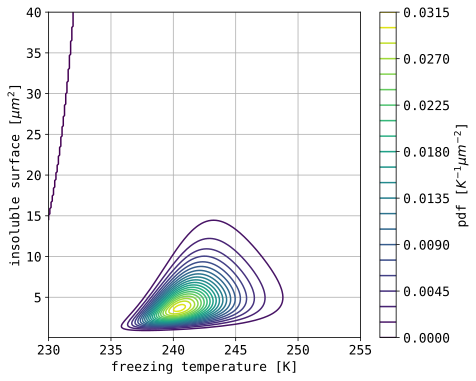

HTML(value="<a href='./tmp8asl4cfz.pdf' target='_blank'>./tmp8asl4cfz.pdf</a><br>")

In [7]:
fig = pyplot.figure(figsize=(7, 6))
ax = fig.add_subplot(111)
ax.set_xlabel('freezing temperature [K]')
ax.set_ylabel('insoluble surface [$μm^2$]')
cnt = ax.contour(grid[0], grid[1] / si.um**2, sampled_pdf * si.um**2, levels=20)
cbar = pyplot.colorbar(cnt)
cbar.set_label('pdf [$K^{-1} μm^{-2}$]')
pyplot.grid()
show_plot()
np.testing.assert_almost_equal(np.sum(sampled_pdf) * dT * dA, 1, decimal=1)

In [8]:
n_samples = 2222
seed = 222
mult = 22

rng = np.random.default_rng(seed)
T_rand = rng.uniform(0, 1, n_samples)
A_rand = rng.uniform(0, 1, n_samples)
data = pdf(
    _01_to_T(T_rand),
    _01_to_A(A_rand)
)

data -= min(data)
data /= max(data)
data *= mult

points_T = []
points_A = []
for i, v in enumerate(np.round(data).astype(dtype=int)):
    for _ in range(v):
        points_T.append(T_rand[i])
        points_A.append(A_rand[i])

data = np.asarray([points_T, points_A]).T

In [9]:
def jointplot(data, title=''):
    h = seaborn.jointplot(x=data[:, 0], y=data[:, 1], kind='hex', label=title)
    h.set_axis_labels(label_T, label_A)
    if title != '':
        pyplot.legend(loc='upper right')

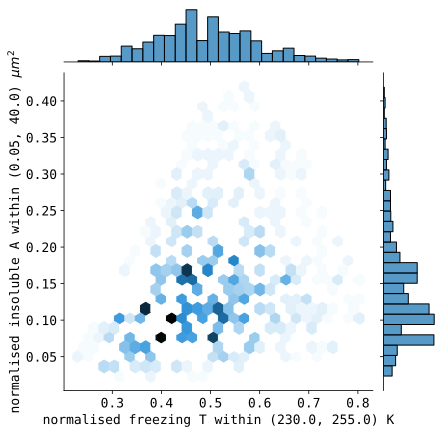

HTML(value="<a href='./01.pdf' target='_blank'>./01.pdf</a><br>")

In [10]:
jointplot(data)
show_plot('01.pdf')

In [11]:
# transform data to uniform (= copula) scale
# (n / (n + 1)) is a correction for the cdf so it stays away from 1
n=data.shape[0]
udata=np.empty((n,2))
udata[:,0]=1-cdfT(_01_to_T(data[:,0]))#*n/(n+1)
udata[:,1]=cdfA(_01_to_A(data[:,1]))#*n/(n+1)

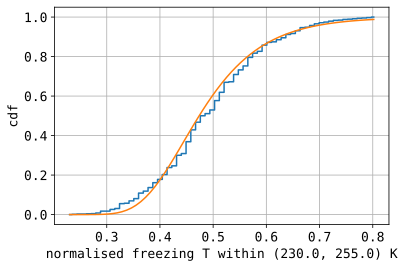

HTML(value="<a href='./tmpsdg__331.pdf' target='_blank'>./tmpsdg__331.pdf</a><br>")

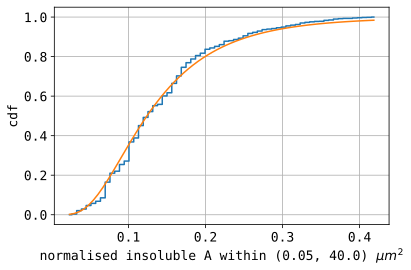

HTML(value="<a href='./tmp_j7ebhcp.pdf' target='_blank'>./tmp_j7ebhcp.pdf</a><br>")

In [12]:
def check_cdf(arg, fun, xlabel):
    histo, bins = np.histogram(arg, bins=64, density=True)
    dx = bins[1] - bins[0]
    cdf = np.concatenate([[0], np.cumsum(histo*dx)])
    pyplot.step(bins, cdf, where='mid')
    pyplot.plot(bins, fun(bins)*n/(n+1))
    pyplot.ylabel('cdf')
    pyplot.xlabel(xlabel)
    pyplot.grid()
    show_plot()

check_cdf(data[:,0], lambda x: 1-cdfT(_01_to_T(x)), xlabel=label_T)
check_cdf(data[:,1], lambda x: cdfA(_01_to_A(x)), xlabel=label_A)

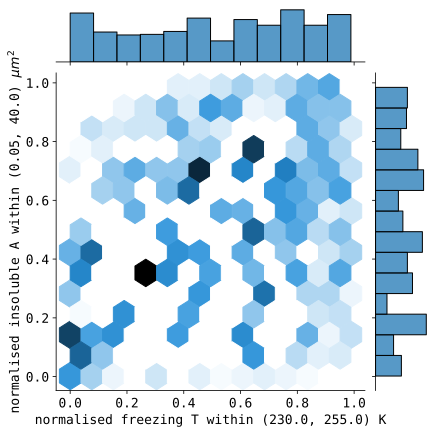

HTML(value="<a href='./02.pdf' target='_blank'>./02.pdf</a><br>")

In [13]:
# udata are almost perfectly uniform by construction
jointplot(udata)
show_plot('02.pdf')

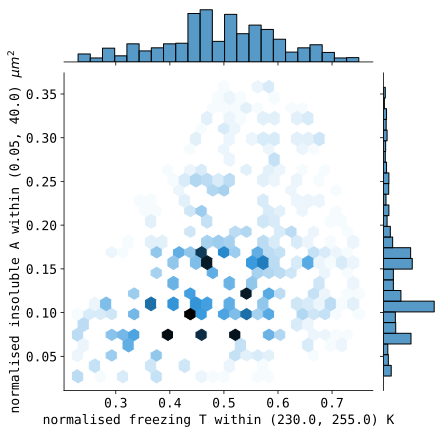

In [14]:
# transform back to original scale
testdata=np.empty((data.shape[0],2))
testdata[:,0]=np.quantile(data[:,0],udata[:,0])
testdata[:,1]=np.quantile(data[:,1],udata[:,1])
jointplot(testdata)

In [15]:
families = (pv.BicopFamily.indep, pv.BicopFamily.tll)
copulae = {}
for family in families:
    copulae[family] = pv.Bicop(udata, controls = pv.FitControlsBicop(family_set=[family]))

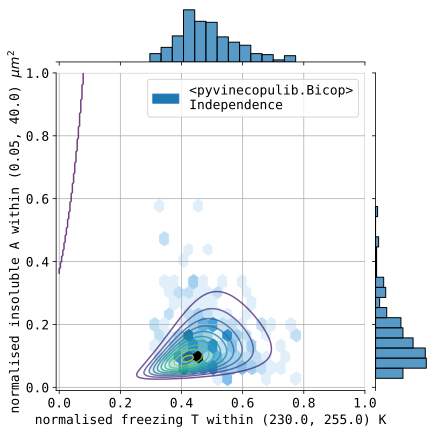

HTML(value="<a href='./03_0.pdf' target='_blank'>./03_0.pdf</a><br>")

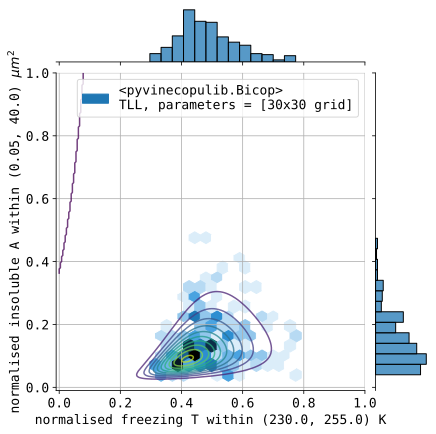

HTML(value="<a href='./03_1.pdf' target='_blank'>./03_1.pdf</a><br>")

In [16]:
for i, family in enumerate(families):    
    simulated = copulae[family].simulate(n=256, seeds=[44])
    copdata=np.empty((simulated.shape[0], 2))
    copdata[:, 0] = _T_to_01(invcdfT(1-simulated[:,0]))
    copdata[:, 1] = _A_to_01(invcdfA(simulated[:,1]))
    
    jointplot(copdata, title=copulae[family])
    pyplot.gca().set_xlim(-.01,1)
    pyplot.gca().set_ylim(-.01,1)
    pyplot.gca().contour(_T_to_01(grid[0]), _A_to_01(grid[1]), sampled_pdf, levels=10, alpha=.75)
    pyplot.grid()
    show_plot(f'03_{i}.pdf')